# Basic elements of an IMAGINE pipeline

In this tutorial, we focus on introducing the basic building blocks of the IMAGINE package and how to use them for assembling a Bayesian analysis pipeline.

We will use mock data with only two independent free parameters. First, we will generate the mock data. Then we will assemble all elements needed for the IMAGINE pipeline, execute the pipeline and investigate its results.

The mock data are designed to "naively" mimic Faraday depth, which is affected linearly by the (Galactic) magnetic field and thermal electron density. As a function of position $x$, we define a constant coherent magnetic field component $a_0$ and a random magnetic field component which is drawn from a Gaussian distribution with standard deviation $b_0$. The electron density is assumed to be independently known and given by a $\cos(x)$ with arbitrary scaling. 
The mock data values we get are related to the Faraday depth of a background source at some arbitrary distance: 

$$ signal(x) = \left[1+\cos(x)\right] \times \mathcal{G}(\mu=a_0,\sigma=b_0;seed=s)\,{\mu\rm G\,cm}^{-3} , \; x \in [0,2\pi]\,\rm kpc$$

where $\{a_0,b_0\}$ is the 'physical' parameter set, and $s$ represents the seed for random variable generation.



The purpose is not to fit the exact signal, since it includes a stochastic component, but to fit the amplitude of the signal and of the variations around it.  So this is fitting the strength of the coherent field $a_0$ and the amplitude of the random field $b_0$.  With these mock data and its (co)variance matrix, we shall assemble the IMAGINE pipeline, execute it and examine its results. 

First, import the necessary packages.

In [1]:
import numpy as np
import logging as log
from astropy.table import Table
import astropy.units as u
import astropy as apy
import corner
import matplotlib.pyplot as plt

import imagine as img

%matplotlib inline

## 1) Preparing the mock data

In calculating the mock data values, we introduce noise as:

$$ data(x) = signal(x) + noise(x) $$

For simplicity, we propose a simple gaussian noise with mean zero and a standard deviation $e$:

$$ noise(x) = \mathcal{G}(\mu=0,\sigma=e) $$ .

We will assume that we have 10 points in the x-direction, in the range $[0, 2\pi]\,\rm kpc$.

In [2]:
a0 = 3. # true value of a in microgauss
b0 = 6. # true value of b in microgauss
e = 0.1 # std of gaussian measurement error
s = 233 # seed fixed for signal field

size = 10 # data size in measurements
x = np.linspace(0.01,2.*np.pi-0.01,size) # where the observer is looking at

np.random.seed(s) # set seed for signal field

signal = (1+np.cos(x)) * np.random.normal(loc=a0,scale=b0,size=size)

fd = signal + np.random.normal(loc=0.,scale=e,size=size)

# We load these to an astropy table for illustration/visualisation
data = Table({'meas' : u.Quantity(fd, u.microgauss*u.cm**-3),
              'err': np.ones_like(fd)*e,
              'x': x,
              'y': np.zeros_like(fd),
              'z': np.zeros_like(fd),
              'other': np.ones_like(fd)*42
              })
data[:4] # Shows the first 4 points in tabular form

meas,err,x,y,z,other
uG / cm3,,,,,
float64,float64,float64,float64,float64,float64
16.4217790817552,0.1,0.01,0.0,0.0,42.0
7.172468731201507,0.1,0.7059094785755097,0.0,0.0,42.0
-3.2254947821460433,0.1,1.4018189571510193,0.0,0.0,42.0
0.27949334758966465,0.1,2.0977284357265287,0.0,0.0,42.0


These data need to be converted to an IMAGINE compatible format. To do this, we first create `TabularDataset` object, 
which helps importing dictionary-like dataset onto IMAGINE.   

In [3]:
mockDataset = img.observables.TabularDataset(data, name='test', 
                                             data_col='meas', 
                                             err_col='err')

These lines simply explain how to read the tabular dataset (note that the 'other' column is ignored): `name` contains the type of observable we are using (here, we use 'test', it could also be 'sync' for synchrotron observables (e.g, Stokes parameters), 'fd' for Faraday Depth, etc. The `data_col` argument specifies the key or name of the column containing the relevant measurement. Coordinates (`coords_type`) can be given in either `'cartesian'` or `'galactic'`. If not provided, the coordinates type is derived from the provided data. In this example, we provided $x$, $y$ and $z$ in $\rm kpc$ and therefore the coordinates type is assumed to be 'cartesian'.
The units of the dataset are represented using [astropy.units](https://docs.astropy.org/en/stable/units/) objects and can be supplied (if they are, the Simulator will later check whether these are adequate and automatically convert the data to other units if needed).


The dataset can be loaded onto a `Measurements` object, which is subclass of `ObservableDict`. This object allows one to supply multiple datasets to the pipeline.

In [4]:
# Create Measurements object using mockDataset
mock_data = img.observables.Measurements(mockDataset)

The dataset object creates a standard key for each appended dataset. In our case, there is only one key.

In [5]:
keys = list(mock_data.keys())
keys

[('test', None, 'tab', None)]

Let us plot the mock data as well as the $1+\cos(x)$ function that is the underlying variation.  

The property `Measurements.global_data` extracts arrays from the `Observable` object which is hosted inside the `ObservableDict` class. 

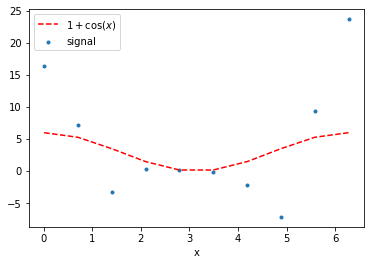

In [6]:
plt.scatter(x, mock_data[keys[0]].global_data[0], marker='.', label='signal')
plt.plot(x,(1+np.cos(x))*a0,'r--',label='$1+\cos(x)$')
plt.xlabel('x'); plt.legend();

Note that the variance in the signal is highest where the $\cos(x)$ is also strongest. This is the way we expect the Faraday depth to work, since a fluctuation in the strength of $\mathbf B$ has a larger effect on the RM when $n_e$ also happens to be higher. 

IMAGINE also comes with a built-in method for showing the contents of a Measurements objects on a skymap. In the next cell this is exemplified, though not very useful for this specific example.

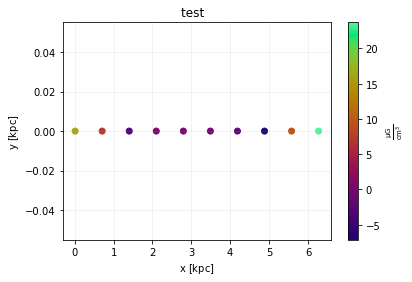

In [7]:
mock_data.show(cartesian_axes='xy')

## 2) Pipeline assembly

Now that we have generated mock data, there are a few steps to set up the pipeline to estimate the input parameters.  We need to specify: a grid, Field Factories, Simulators, and Likelihoods.

### Setting the coordinate grid

Fields in IMAGINE represent models of any kind of physical field -- in this particular tutorial, we will need a magnetic field and thermal electron density. 

The Fields are evaluated on a grid of coordinates, represented by a `img.Grid` object. Here we exemplify how to produce a *regular cartesian* grid. To do so, we need to specify the values of the coordinates on the 6 extremities of the box (i.e. the minimum and maximum value for each coordinate), and the resolution over each dimension.  

For this particular artificial example, we actually only need one dimension, 
so we set the resolution to 1 for $y$ and $z$. 

In [8]:
one_d_grid = img.fields.UniformGrid(box=[[0,2*np.pi]*u.kpc,
                                         [0,0]*u.kpc,
                                         [0,0]*u.kpc],
                                    resolution=[30,1,1])

### Preparing the Field Factory list

A particular realisation of a model for a physical field is represented within IMAGINE by a *Field* object, which, given set of parameters, evaluates the field for over the grid.  

A *Field Factory* is an associated piece of infrastructure used by the Pipeline to produce new Fields. It is a Factory object that needs to be initialized and supplied to the Pipeline. This is what we will illustrate here. 


In [9]:
from imagine import fields
ne_factory = fields.CosThermalElectronDensityFactory(grid=one_d_grid)

The previous line instantiates `CosThermalElectronDensityFactory` with the previously defined Grid object. This Factory allows the Pipeline to produce
`CosThermalElectronDensity` objects. These correspond to a toy model for electron density with the form: 
$$n_e(x,y,z) = n_0 [1+\cos (a x + \alpha)][1+\cos (b y + \beta)][1+\cos(c z + \gamma)]\,. $$ 

We can set and check the default parameter values in the following way:

In [10]:
ne_factory.default_parameters= {'a': 1*u.rad/u.kpc,
                                'beta':  np.pi/2*u.rad, 
                                'gamma': np.pi/2*u.rad}
ne_factory.default_parameters

{'n0': <Quantity 1. 1 / cm3>,
 'a': <Quantity 1. rad / kpc>,
 'b': <Quantity 0. rad / kpc>,
 'c': <Quantity 0. rad / kpc>,
 'alpha': <Quantity 0. rad>,
 'beta': <Quantity 1.57079633 rad>,
 'gamma': <Quantity 1.57079633 rad>}

In [11]:
ne_factory.active_parameters

()

For `ne_factory`, no active parameters were set. This means that the Field will be always evaluated using the specified default parameter values.

We will now similarly define the magnetic field, using the `NaiveGaussianMagneticField` which constructs a "naive" random field (i.e. the magnitude of $x$, $y$ and $z$ components of the field are drawn from a Gaussian distribution **without** imposing *zero divergence*, thus *do not use this for serious applications*).

In [12]:
B_factory = fields.NaiveGaussianMagneticFieldFactory(grid=one_d_grid)

Differently from the case of `ne_factory`, in this case we would like to make the parameters active. All individual components of the field are drawn from a Gaussian distribution with mean $a_0$ and standard deviation $b_0$. To set these parameters as active we do:

In [13]:
B_factory.active_parameters = ('a0','b0')
B_factory.priors ={'a0': img.priors.FlatPrior(xmin=-4*u.microgauss,
                                              xmax=5*u.microgauss),
                   'b0': img.priors.FlatPrior(xmin=2*u.microgauss,
                                              xmax=10*u.microgauss)}

In the lines above we chose uniform (flat) priors for both parameters within the above specified ranges. Any active parameter must have a Prior distribution specified.

Once the two FieldFactory objects are prepared, they put together in a list which is later supplied to the Pipeline.

In [14]:
factory_list = [ne_factory, B_factory]

### Initializing the Simulator

For this tutorial, we use a customized TestSimulator which simply computes the quantity: $t(x,y,z) = B_y\,n_e\,$,i.e. the contribution at one specific point to the Faraday depth.

The simulator is initialized with the mock Measurements defined before, which allows it to know what is the correct format for output.

In [15]:
from imagine.simulators import TestSimulator
simer = TestSimulator(mock_data)

### Initializing the Likelihood
IMAGINE provides the `Likelihood` class with `EnsembleLikelihood` and `SimpleLikelihood` as two options.  The `SimpleLikelihood` is what you expect, computing a single $\chi^2$ from the difference of the simulated and the measured datasets.  The `EnsembleLikelihood` is how IMAGINE handles a signal which itself includes a stochastic component, e.g., what we call the Galactic variance.  This likelihood module makes use of a finite ensemble of simulated realizations and uses their mean and covariance to compare them to the measured dataset.  

In [16]:
likelihood = img.likelihoods.EnsembleLikelihood(mock_data)

## 3) Running the pipeline

Now we have all the necessary components available to run our pipeline. This can be done through a `Pipeline` object, which interfaces with some algorithm to sample the likelihood space accounting for the prescribed prior distributions for the parameters. 

IMAGINE comes with a range of samplers coded as different Pipeline classes, most of which are based on the nested sampling approach. 
In what follows we will use the [MultiNest](http://johannesbuchner.github.io/PyMultiNest/) sampler as an example.

IMAGINE takes care of stochastic fields by evaluating an ensemble of random realisations for each selected point in the parameter space, and computing the associated covariance (i.e. estimating the [Galactic variance](https://ui.adsabs.harvard.edu/abs/2010MNRAS.401.1013J/abstract)). We can set this up through the `ensemble_size` argument.

Now we are ready to initialize our final pipeline.

In [17]:
pipeline = img.pipelines.MultinestPipeline(simulator=simer, 
                                           run_directory=None,
                                           factory_list=factory_list, 
                                           likelihood=likelihood, 
                                           ensemble_size=27)

The `run_directory` keyword is used to setup where the state of the pipeline is saved (allowing loading the pipeline in the future). It is also where the chains generated by the sampler are saved in the sampler's native format (if the sampler supports this). If this argument is absent or set to `None`, a temporary directory is created – and is automatically removed when the Pipeline object becomes out of scope (e.g. when one runs `del pipeline` or exits the script/notebook).  

It is usually a good idea to manually choose a `run_directory`, but for quick tests like this one, we may set it to `None` and use the temporary directory. After initialization, we can check this choice inspecting the `run_directory` property:

In [18]:
pipeline.run_directory

'/tmp/imagine_y5duh5gk/imagine_run_vpfqknkh'

The property `sampling_controllers` allows one to send sampler-specific parameters to the chosen Pipeline. 
Each IMAGINE Pipeline object will have slightly different sampling controllers, which can be found in the specific Pipeline's docstring.

In [19]:
pipeline.sampling_controllers = {'evidence_tolerance': 0.5, 'n_live_points': 200}

In a standard *nested sampling approach*, a set of "live points" is initially sampled from the prior distribution. After each iteration the point with the smallest likelihood is removed (it becomes a *dead point*, and its likelihood value is stored) and a new point is sampled from the prior. As each dead point is associated to some prior volume, they can be used to estimate the evidence (see, e.g. [here](https://dynesty.readthedocs.io/en/latest/overview.html#basic-algorithm) for details).  In the `MultinestPipeline`, the number of live points is set using the `'n_live_points'` sampling controller.

The sampling parameter `'evidence_tolerance'` allows one to control the target error in the estimated evidence.



<!-- for `'DynestyPipeline'` (not in dynamic mode) this corresponds to `'nlive'`. `'UltranestPipeline'` and `'DynestyPipeline'` (in dynamic mode) can both change the number of live points on-the-fly, but allow one to set a minimum or initial number o live points, respectively, `'min_num_live_points'` and `'nlive_init'`.
`MultinestPipeline` allows one to set a log-evidence error target, using using the `'evidence_tolerance'`.  
 -->
<!-- One would rather set the target estimated uncertainty in the model evidence and/or target posterior uncertainty, and allow the model to converge to it. This can be done using the following sampling controllers (do check individual docstrings for details). In `UltranestPipeline` this is done using `'dlogZ'` for target log-evidence error and `'dKL'` for target posterior error.In `DynestyPipeline` the log-evidence error can be controlled using: `'dlogz'` (also `'dlogz_init'`), but the sampler can also try to optimize the estimate of the posterior while running in the *dynamic* mode.

The `UltranestPipeline`, for example, allows one to set a limit on the number of likelihood evaluations using the sampling controller `'max_ncalls'`). This is convenient for quick tests and examples (as this tutorial). Similar functionality is available in the `DynestyPipeline` under the name `'max_call'` (and also `'max_call_init'`/`'max_call_batch'` for dynamic nested sampling).

 -->

Now, we *finally* can run the pipeline!

  analysing data from /tmp/imagine_y5duh5gk/imagine_run_vpfqknkh/chains/multinest_.txt



**Posterior report:**

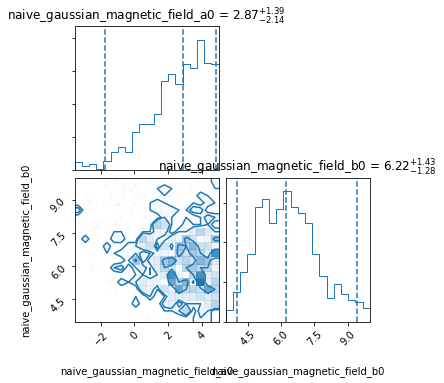

<IPython.core.display.Math object>

**Evidence report:**

<IPython.core.display.Math object>

In [20]:
results = pipeline()

Thus, one can see that after the pipeline finishes running, a brief summary report is written to screen.  

When one runs the pipeline it returns a results dictionary object in the native format of the chosen sampler.  Alternatively, after running the pipeline object, the results can also be accessed through its attributes, which are standard interfaces (i.e. all pipelines should work in the same way). 

For comparing different models, the quantity of interest is the *model evidence* (or *marginal likelihood*) $\mathcal Z$. After a run, this can be easily accessed as follows.

In [21]:
print('log evidence:', round(pipeline.log_evidence,4))
print('log evidence error:', round(pipeline.log_evidence_err,4))

log evidence: -33.7532
log evidence error: 0.0677


A dictionary containing a summary of the *constraints to the parameters* can be  accessed through the property `posterior_summary`:

In [22]:
pipeline.posterior_summary

{'naive_gaussian_magnetic_field_a0': {'median': <Quantity 2.87279227 uG>,
  'errlo': <Quantity 2.14772695 uG>,
  'errup': <Quantity 1.39470874 uG>,
  'mean': <Quantity 2.53997992 uG>,
  'stdev': <Quantity 1.76557802 uG>},
 'naive_gaussian_magnetic_field_b0': {'median': <Quantity 6.22234717 uG>,
  'errlo': <Quantity 1.27939723 uG>,
  'errup': <Quantity 1.42967741 uG>,
  'mean': <Quantity 6.3207014 uG>,
  'stdev': <Quantity 1.34561245 uG>}}

In most cases, however, one would (should) prefer to work directly on the samples produced by the sampler. 
A table containing the parameter values of the samples generated can be accessed through:

In [23]:
samples = pipeline.samples
samples[:3] # Displays only first 3 rows

naive_gaussian_magnetic_field_a0,naive_gaussian_magnetic_field_b0
uG,uG
float64,float64
0.800451397895813,3.6197452545166016
-1.1316596269607544,4.804409503936768
-2.5341084003448486,5.928710460662842


For convenience, the corner plot showing the posterior distribution obtained from the samples can be generated using the `corner_plot` method of the `Pipeline` object
(which uses the [corner](https://corner.readthedocs.io/en/latest/) library). This can show "truth" values of the parameters (in case someone is doing a test like this one).

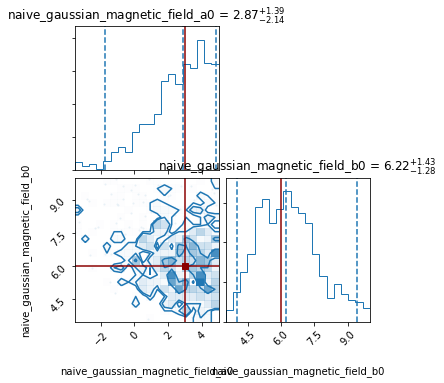

In [24]:
pipeline.corner_plot(truths_dict={'naive_gaussian_magnetic_field_a0': 3,
                                  'naive_gaussian_magnetic_field_b0': 6});

One can, of course, choose other plotting/analysis routines. Below, the use of [seaborn](http://seaborn.pydata.org) is exemplified.

In [25]:
import seaborn as sns
def plot_samples_seaborn(samp):
    
    def show_truth_in_jointplot(jointplot, true_x, true_y, color='r'):
        for ax in (jointplot.ax_joint, jointplot.ax_marg_x):
            ax.vlines([true_x], *ax.get_ylim(), colors=color)
        for ax in (jointplot.ax_joint, jointplot.ax_marg_y):
            ax.hlines([true_y], *ax.get_xlim(), colors=color)

    snsfig = sns.jointplot(*samp.colnames, data=samp.to_pandas(), kind='kde')
    snsfig.plot_joint(sns.scatterplot, linewidth=0, marker='.', color='0.3')
    show_truth_in_jointplot(snsfig, a0, b0)

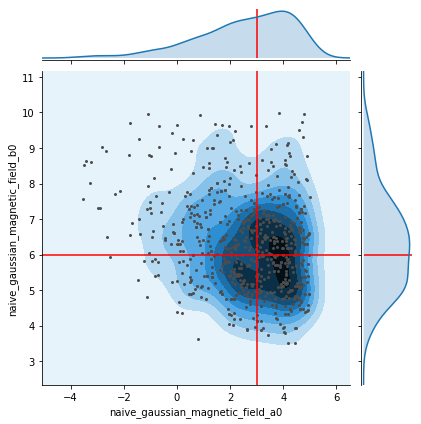

In [26]:
plot_samples_seaborn(samples)

## Random seeds and convergence checks

The pipeline relies on random numbers in multiple ways. 
The Monte Carlo sampler will draw randomly chosen points in the parameter space duing its exploration (in the specific case of *nested sampling* pipelines, these are drawn from the prior distributions). Also, while evaluating the fields at each point, random realisations of the stochastic fields are generated.

It is possible to control the behaviour of the random seeding of an IMAGINE pipeline through the attribute `master_seed`. This attribute has two uses: it is passed to the sampler, ensuring that its behaviour is reproducible; and it is also used to generate a fresh list of new random seeds to each stochastic field that is evaluated. 

In [27]:
pipeline.master_seed

1

By default, the master seed is fixed and set to 1, but you can alter its value before running the pipeline. 

One can also change the seeding behaviour through the `random_type` attribute. There are three allowed options for this:

* 'controllable' - the `master_seed` is constant and a re-running the pipeline should lead to the exact same results (default), and the random seeds which are used for generating the ensembles of stochastic fields are drawn in the beginning of the pipeline run;
* 'free' - on each execution, a new `master_seed` is drawn (using numpy.randint), moreover: at *each evaluation of the likelihood* the stochastic fields receive a new set of ensemble seeds;
* 'fixed' - this mode is for debugging purposes. The `master_seed` is fixed, as in the 'controllable' case, however each individual stochastic field receives the exact same list of ensemble seeds every time (while in the `controllable` these are chosen "randomly" at run-time). Such choice can be inspected using `pipeline.ensemble_seeds`.

Let us now check whether different executions of the pipeline are generating consistent results.
To do so, we run it five times and just overplot histograms of the outputs to see if they all look the same. There are more rigorous tests, of course, that we have done, but they take longer.  The following can be done in a few minutes.

------------------------------------------------------------
Run 1/5
log Z =  -33.7532 ± 0.0677
------------------------------------------------------------
Run 2/5
  analysing data from /tmp/imagine_y5duh5gk/imagine_run_vpfqknkh/chains/multinest_.txt
log Z =  -36.3703 ± 0.0602
------------------------------------------------------------
Run 3/5
  analysing data from /tmp/imagine_y5duh5gk/imagine_run_vpfqknkh/chains/multinest_.txt
log Z =  -33.5999 ± 0.079
------------------------------------------------------------
Run 4/5
  analysing data from /tmp/imagine_y5duh5gk/imagine_run_vpfqknkh/chains/multinest_.txt
log Z =  -33.3205 ± 0.0643
------------------------------------------------------------
Run 5/5
  analysing data from /tmp/imagine_y5duh5gk/imagine_run_vpfqknkh/chains/multinest_.txt
log Z =  -34.7233 ± 0.0661


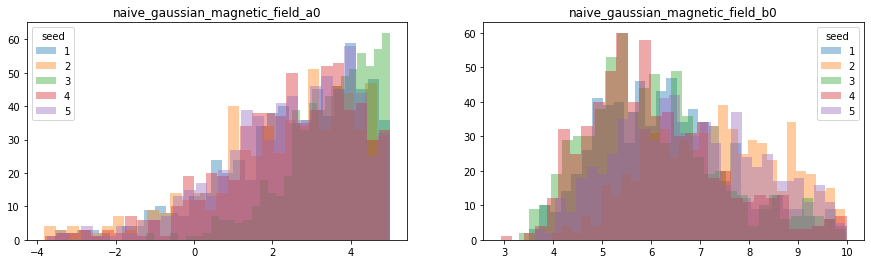

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
repeat = 5
pipeline.show_summary_reports = False  # Avoid summary reports
pipeline.sampling_controllers['resume'] = False # Pipeline will re-run
samples_list = []
for i in range(1,repeat+1):   
    print('-'*60+'\nRun {}/{}'.format(i,repeat))
    if i>1: 
        # Re-runs the pipeline with a different seed
        pipeline.master_seed = i
        _ = pipeline()
    print('log Z = ', round(pipeline.log_evidence,4), 
          '±', round(pipeline.log_evidence_err,4))
    
    samples = pipeline.samples
    
    for j, param in enumerate(pipeline.samples.columns):
        samp = samples[param]
        axs[j].hist(samp.value, alpha=0.4, bins=30, label=pipeline.master_seed)
        axs[j].set_title(param)
    # Stores the samples for later use
    samples_list.append(samples)

for i in range(2):
    axs[i].legend(title='seed')

After being satisfied, one may want to put together all the samples. A set of rigorous tools for combining multiple pipelines/runs is *currently under development*, but a first order approximation to this can be seen below:

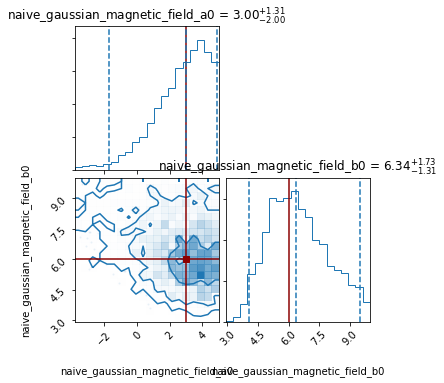

In [29]:
all_samples = apy.table.vstack(samples_list)
img.tools.corner_plot(table=all_samples,
                      truths_dict={'naive_gaussian_magnetic_field_a0': 3,
                                   'naive_gaussian_magnetic_field_b0': 6});

## Script example

A script version of this tutorial can be found in the [examples directory](https://github.com/IMAGINE-Consortium/imagine/tree/master/examples/basic_pipeline.py).
